<p style="font-size: 30px">Fix policy in Q-Learning & Policy Iteration</p>

This script is used to compare the tabular Q-Learning and policy iteration with the optimal policy from dual LP.

In [1]:
# a temporary solution, run twice to set the current path as '../Fair-RL/src'
%cd ..

/Users/xiaohui/SpyderProjects/PhD/Fair-RL/src


In [2]:
# used to auto-reload imported module after making modification inside .py files
%load_ext autoreload
%autoreload 2

In [3]:
import argparse

from env.mrp_env import MachineReplace
from experiments.configs.config_shared import prs_parser_setup
import seaborn as sns
import numpy as np


# configuration parameters
prs = argparse.ArgumentParser(
    formatter_class=argparse.ArgumentDefaultsHelpFormatter,
    description="""Tabular Q Learning.""",
)
prs = prs_parser_setup(prs)
args, _ = prs.parse_known_args()

# check parameters
args

Namespace(ggi=False, n_action=2, n_group=3, n_state=3, weight=2)

# Fair LP Model

## MOMDP

summed rewards

In [37]:
from solver.momdp import build_mrp, extract_results, solve_mrp
from utils.mrp_lp import MRPData

# Get the MRP data
input_data = MRPData(n_group=3, n_state=3, n_action=2, weight=[1, 0.5, 0.25])
# Build the MOMDP model
momdp_model = build_mrp(data=input_data)
# Solve the MOMDP model
results, momdp_model = solve_mrp(model=momdp_model)
# Extract the results
extract_results(model=momdp_model, data=input_data)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 27 rows, 108 columns and 602 nonzeros
Model fingerprint: 0xf2355ac7
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 0 rows and 13 columns
Presolve time: 0.01s
Presolved: 27 rows, 95 columns, 589 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.000000e+00   0.000000e+00      0s
      27    3.8849318e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.884931784e+01
x((0, 0, 0), 0): 0.0935287666885296
x((0, 0, 1), 0): 0.06576860462233479
x((0, 0, 2), 0): 0.04778972520908004
x((0, 1, 0), 0): 0.06576860462233479
x((0, 1, 1), 0):

[34.981941185583345, 41.7835978242931, 48.450264490959775]

## Dual LP
Optimal solutions from dual LP are given as:

In [21]:
import numpy as np

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

# results for ggf dual
from solver.ggf_dual import build_ggf, extract_results, solve_ggf

# Build t1he GGF model
ggf_model_lp = build_ggf(data=data_mrp)
# Solve the GGF model
results_lp, ggf_model_lp = solve_ggf(model=ggf_model_lp)
# Extract the results
extract_results(model=ggf_model_lp, data=data_mrp)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 36 rows, 114 columns and 1592 nonzeros
Model fingerprint: 0xcfb725c3
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve time: 0.00s
Presolved: 36 rows, 114 columns, 1592 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.259259e+00   0.000000e+00      0s
      60    4.1508739e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.150873891e+01
x((0, 0, 0), 0): 0.08962194783040893
x((0, 0, 1), 0): 0.065000707827664
x((0, 0, 2), 0): 0.04778972520908004
x((0, 1, 0), 0): 0.065000707827664
x((0, 1, 1), 0): 0.04702182841440925
x((0, 1, 2), 3): 0

[41.50873891260395, 41.508738912603974, 41.508738912603974]

# Tabular Q-learning

## Sum Rewards


1. Select $a \in \mathcal{A}$ according to $\epsilon$-greedy.

    $
\pi(a|s)=\left\{\begin{array}{l}1-\epsilon \text { if } a= \arg \max_a Q^\pi (s, a) \\ \epsilon /(|\mathcal{A}|-1) \text { otherwise }\end{array}\right.
$
    
2. Update Q table: $\mathbf{Q}\left(s, a\right) \leftarrow \mathbf{Q}\left(s, a\right)+\alpha\left[r(s, a)+\gamma \max _{a} \mathbf{Q}\left(s^\prime, a\right)-\mathbf{Q}\left(s,a\right)\right]$

Two conditions must be met to guarantee convergence in the limit (Watkins & Dayan, 1992), meaning that the policy will become arbitrarily close to the optimal policy after an arbitrarily long period of time. Note that these conditions say nothing about how fast the policy will approach the optimal policy.

1. **The learning rates must approach zero, but not too quickly**. Formally, this requires that the sum of the learning rates must diverge, but the sum of their squares must converge. An example sequence that has these properties is 1/1, 1/2, 1/3, 1/4, ...

2. **Each state-action pair must be visited infinitely often**. This has a precise mathematical definition: each action must have a non-zero probability of being selected by the policy in every state, i.e. π(s, a) > 0 for all (s, a). In practice, using an ε-greedy policy (where ε > 0) ensures that this condition is satisfied.

In [4]:
from algorithms.tabular_q import QAgent, run_tabular_q

In [45]:
# initialize the MRP environment
env = MachineReplace(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    init_state=0,
    ggi=args.ggi,
)

tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=500, len_episode=1500, alpha=0.1, epsilon=0.6, decaying_factor=0.99, gamma=0.90
)

Episode: 20; Running Reward: 1826.5; Epsilon: 0.491; Learning Rate: 0.096
Episode: 40; Running Reward: 1796.7; Epsilon: 0.401; Learning Rate: 0.092
Episode: 60; Running Reward: 1911.3; Epsilon: 0.328; Learning Rate: 0.088
Episode: 80; Running Reward: 1870.0; Epsilon: 0.269; Learning Rate: 0.084
Episode: 100; Running Reward: 1884.1; Epsilon: 0.220; Learning Rate: 0.080
Episode: 120; Running Reward: 2077.9; Epsilon: 0.180; Learning Rate: 0.076
Episode: 140; Running Reward: 1880.7; Epsilon: 0.147; Learning Rate: 0.072
Episode: 160; Running Reward: 1850.3; Epsilon: 0.120; Learning Rate: 0.068
Episode: 180; Running Reward: 1807.0; Epsilon: 0.098; Learning Rate: 0.064
Episode: 200; Running Reward: 1978.3; Epsilon: 0.080; Learning Rate: 0.060
Episode: 220; Running Reward: 1853.6; Epsilon: 0.066; Learning Rate: 0.056
Episode: 240; Running Reward: 2134.0; Epsilon: 0.054; Learning Rate: 0.052
Episode: 260; Running Reward: 2026.8; Epsilon: 0.044; Learning Rate: 0.048
Episode: 280; Running Reward:

<AxesSubplot:>

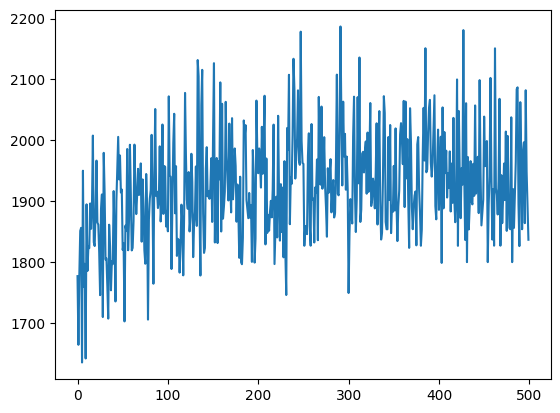

In [46]:
sns.lineplot(episode_rewards)

Next, we fix the policy from q-learning and solve.

In [47]:
import numpy as np

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x6f75658e
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.00s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.883536e+02   0.000000e+00      0s
       5    3.0436290e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.043629020e+02
x((0, 0, 0), 3): 0.3629246052342043
x((0, 0, 1), 2): 0.36320651315662317
x((0, 0, 2), 0): 0.3155260926355506
x((0, 1, 0), 0): 0.43244952647409857
x((0, 1, 1), 0):

[780.0, 820.0, 880.0]

### Optimistic Initialization

In [8]:
from algorithms.tabular_q import QAgent, run_tabular_q

# initialize the MRP environment
env = MachineReplace(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    init_state=0,
    ggi=args.ggi,
)

tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=500, len_episode=1500, alpha=0.1, epsilon=0.2, decaying_factor=1.0, gamma=0.90
)

Episode: 0; Running Reward: 1715.9; Epsilon: 0.198; Learning Rate: 0.100
Episode: 20; Running Reward: 1684.0; Epsilon: 0.162; Learning Rate: 0.096
Episode: 40; Running Reward: 1981.7; Epsilon: 0.132; Learning Rate: 0.092
Episode: 60; Running Reward: 1863.9; Epsilon: 0.108; Learning Rate: 0.088
Episode: 80; Running Reward: 1961.0; Epsilon: 0.089; Learning Rate: 0.084
Episode: 100; Running Reward: 1880.1; Epsilon: 0.072; Learning Rate: 0.080
Episode: 120; Running Reward: 1934.6; Epsilon: 0.059; Learning Rate: 0.076
Episode: 140; Running Reward: 1998.6; Epsilon: 0.048; Learning Rate: 0.072
Episode: 160; Running Reward: 2192.6; Epsilon: 0.040; Learning Rate: 0.068
Episode: 180; Running Reward: 2075.1; Epsilon: 0.032; Learning Rate: 0.064
Episode: 200; Running Reward: 1995.9; Epsilon: 0.027; Learning Rate: 0.060
Episode: 220; Running Reward: 2035.3; Epsilon: 0.022; Learning Rate: 0.056
Episode: 240; Running Reward: 1981.0; Epsilon: 0.018; Learning Rate: 0.052
Episode: 260; Running Reward: 1

<AxesSubplot:>

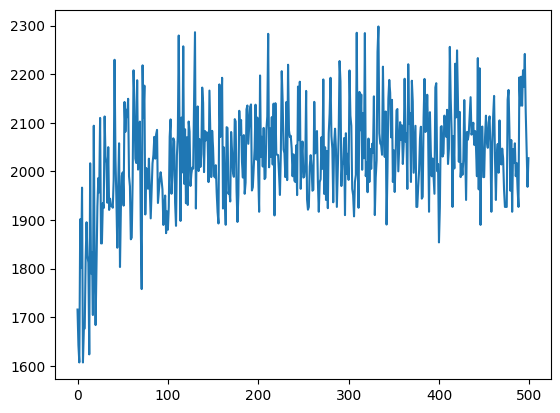

In [10]:
sns.lineplot(episode_rewards)

In [9]:
import numpy as np

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x9530d6db
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.00s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.000000e+02   0.000000e+00      0s
       5    2.6666667e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.666666667e+02
x((0, 0, 0), 0): 0.37037037037037046
x((0, 0, 1), 0): 0.37037037037037046
x((0, 0, 2), 0): 0.3703703703703704
x((0, 1, 0), 0): 0.37037037037037046
x((0, 1, 1), 0)

[720.0, 720.0, 720.0]

### Reward Redesign

Examine the reward structure of our problem.

1. use minus reward does not help

2. [wrong] increase the discrepancy of replace cost and operation cost

   If the replacement cost is too high, we tend to not to fix the machine.
   
3. Redesign the rewards by decreasing the discrepancy of the replacement cost and the operation cost to encourage the agent to take the desired action.

    seems to work?

#### [x] minus reward

Optimal objective  3.306614269e+02

In [33]:
from algorithms.tabular_q import QAgent, run_tabular_q

# initialize the MRP environment
env = MachineReplace(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    init_state=0,
    ggi=args.ggi,
)

tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=500, len_episode=1500, alpha=0.1, epsilon=0.6, decaying_factor=0.99, gamma=0.90
)

Episode: 20; Running Reward: 1916.8; Epsilon: 0.491; Learning Rate: 0.096
Episode: 40; Running Reward: 1750.4; Epsilon: 0.401; Learning Rate: 0.092
Episode: 60; Running Reward: 1855.0; Epsilon: 0.328; Learning Rate: 0.088
Episode: 80; Running Reward: 1909.3; Epsilon: 0.269; Learning Rate: 0.084
Episode: 100; Running Reward: 1887.7; Epsilon: 0.220; Learning Rate: 0.080
Episode: 120; Running Reward: 1739.4; Epsilon: 0.180; Learning Rate: 0.076
Episode: 140; Running Reward: 1880.1; Epsilon: 0.147; Learning Rate: 0.072
Episode: 160; Running Reward: 1772.2; Epsilon: 0.120; Learning Rate: 0.068
Episode: 180; Running Reward: 2093.0; Epsilon: 0.098; Learning Rate: 0.064
Episode: 200; Running Reward: 1872.3; Epsilon: 0.080; Learning Rate: 0.060
Episode: 220; Running Reward: 1904.9; Epsilon: 0.066; Learning Rate: 0.056
Episode: 240; Running Reward: 2039.9; Epsilon: 0.054; Learning Rate: 0.052
Episode: 260; Running Reward: 1833.8; Epsilon: 0.044; Learning Rate: 0.048
Episode: 280; Running Reward:

In [34]:
import numpy as np

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x6c1c8cb5
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.01s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.245525e+02   0.000000e+00      0s
       5    3.3066143e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.306614269e+02
x((0, 0, 0), 1): 0.39672868042992004
x((0, 0, 1), 2): 0.34981313696538663
x((0, 0, 2), 0): 0.3391528885805681
x((0, 1, 0), 1): 0.44406316684695724
x((0, 1, 1), 0)

[980.0, 820.0, 720.0]

In [18]:
from algorithms.tabular_q import QAgent, run_tabular_q

# initialize the MRP environment
env = MachineReplace(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    init_state=0,
    ggi=args.ggi,
)

tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=500, len_episode=1500, alpha=0.1, epsilon=0.6, decaying_factor=0.99, gamma=0.90
)

Episode: 0; Running Reward: -9831.4; Epsilon: 0.594; Learning Rate: 0.100
Episode: 20; Running Reward: -4093.1; Epsilon: 0.486; Learning Rate: 0.096
Episode: 40; Running Reward: -3007.4; Epsilon: 0.397; Learning Rate: 0.092
Episode: 60; Running Reward: -2878.1; Epsilon: 0.325; Learning Rate: 0.088
Episode: 80; Running Reward: -2117.5; Epsilon: 0.266; Learning Rate: 0.084
Episode: 100; Running Reward: -2835.9; Epsilon: 0.217; Learning Rate: 0.080
Episode: 120; Running Reward: -2597.4; Epsilon: 0.178; Learning Rate: 0.076
Episode: 140; Running Reward: -3306.3; Epsilon: 0.145; Learning Rate: 0.072
Episode: 160; Running Reward: -1357.9; Epsilon: 0.119; Learning Rate: 0.068
Episode: 180; Running Reward: -1470.3; Epsilon: 0.097; Learning Rate: 0.064
Episode: 200; Running Reward: -1264.9; Epsilon: 0.080; Learning Rate: 0.060
Episode: 220; Running Reward: -1354.7; Epsilon: 0.065; Learning Rate: 0.056
Episode: 240; Running Reward: -1244.4; Epsilon: 0.053; Learning Rate: 0.052
Episode: 260; Runn

#### descrese the replacement cost

operation cost = [10, 20, 50]

replacement cost is reduced from 100 to 60.

In [60]:
tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=500, len_episode=1500, alpha=0.1, epsilon=0.6, decaying_factor=0.99, gamma=0.90
)

Episode: 20; Running Reward: 2025.1; Epsilon: 0.491; Learning Rate: 0.096
Episode: 40; Running Reward: 1957.9; Epsilon: 0.401; Learning Rate: 0.092
Episode: 60; Running Reward: 1968.5; Epsilon: 0.328; Learning Rate: 0.088
Episode: 80; Running Reward: 1941.4; Epsilon: 0.269; Learning Rate: 0.084
Episode: 100; Running Reward: 1997.5; Epsilon: 0.220; Learning Rate: 0.080
Episode: 120; Running Reward: 2171.2; Epsilon: 0.180; Learning Rate: 0.076
Episode: 140; Running Reward: 1858.9; Epsilon: 0.147; Learning Rate: 0.072
Episode: 160; Running Reward: 2000.2; Epsilon: 0.120; Learning Rate: 0.068
Episode: 180; Running Reward: 1932.5; Epsilon: 0.098; Learning Rate: 0.064
Episode: 200; Running Reward: 2064.9; Epsilon: 0.080; Learning Rate: 0.060
Episode: 220; Running Reward: 2051.8; Epsilon: 0.066; Learning Rate: 0.056
Episode: 240; Running Reward: 2112.9; Epsilon: 0.054; Learning Rate: 0.052
Episode: 260; Running Reward: 2213.6; Epsilon: 0.044; Learning Rate: 0.048
Episode: 280; Running Reward:

In [63]:
tabular_q_policy = {0: 0, 1: 0, 2: 3, 3: 0, 4: 0, 5: 3, 6: 2, 7: 2, 8: 3, 9: 0, 10: 0, 11: 3, 12: 0, 13: 0, 14: 3, 15: 2, 16: 2, 17: 2, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 3, 24: 2, 25: 1, 26: 2}

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0xe12a1862
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.00s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.999062e+01   0.000000e+00      0s
       5    3.3506573e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.350657275e+01
x((0, 0, 0), 0): 0.08731825744639655
x((0, 0, 1), 0): 0.058942855336372155
x((0, 0, 2), 3): 0.037037037037037035
x((0, 1, 0), 0): 0.058942855336372155
x((0, 1, 1)

[840.0, 860.0, 840.0]

In [57]:
# Build t1he GGF model
ggf_model_lp = build_ggf(data=data_mrp)
# Solve the GGF model
results_lp, ggf_model_lp = solve_ggf(model=ggf_model_lp)
# Extract the results
extract_results(model=ggf_model_lp, data=data_mrp)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 36 rows, 114 columns and 1592 nonzeros
Model fingerprint: 0xf6c5750b
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve time: 0.01s
Presolved: 36 rows, 114 columns, 1592 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.259259e+00   0.000000e+00      0s
      40    3.3330206e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.333020591e+01
x((0, 0, 0), 0): 0.08731825744639655
x((0, 0, 1), 0): 0.058942855336372155
x((0, 0, 2), 3): 0.037037037037037035
x((0, 1, 0), 0): 0.058942855336372155
x((0, 1, 1), 0): 0.04702182841440925
x((0, 1, 2)

[33.33020590990865, 33.33020590990865, 33.330205909908656]

# Policy Iteration

## MO

closer to the optimal (LP Optimal objective  3.884931784e+01 vs. PI Optimal objective  4.271292196e+01)

**Policy Iteration**

1. Policy Evaluation: $V^\pi (s) \leftarrow r({s}, \pi({s})) + \gamma E_{{s}^\prime \sim p({s}^\prime | {s}, \pi({s}))}[V^\pi({s}^\prime)]$
2. Policy Improvement: $\pi \leftarrow \pi^\prime$, where
    
    $\pi^\prime({a}|{s})$ = 1 if ${a} = \arg \max_{{a}} Q^\pi({s}, {a})$ and 0 otherwise

Optimal objective  4.271292196e+01

In [23]:
"""This script is used to run policy iteration algorithm."""

import numpy as np

from utils.mrp_lp import MRPData


class PIAgent:
    def __init__(self, params, gamma=0.99, theta=1e-10):
        self.mrp_data = MRPData(
            n_group=params["n_group"],
            n_state=params["n_state"],
            n_action=params["n_action"],
            weight=None
        )
        self.ggi = params["ggi"]
        self.gamma = gamma  # discount factor
        self.theta = theta  # threshold to stop policy evaluation
        self.n_state = len(self.mrp_data.idx_list_s)
        self.n_action = len(self.mrp_data.idx_list_a)

    def policy_evaluation(self, pi, ggi):
        if not self.ggi:
            prev_V = np.zeros(self.n_state, dtype=np.float64)
        while True:
            V = np.zeros(self.n_state, dtype=np.float64)
            for s in range(self.n_state):
                next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                reward = sum(-self.mrp_data.bigC[s, pi(s), :] + 110)
                V[s] += reward + self.gamma * np.dot(prev_V, next_state_prob)
            if np.max(np.abs(prev_V - V)) < self.theta:
                break
            prev_V = V.copy()
        return V

    def policy_improvement(self, V, ggi):
        Q = np.zeros((self.n_state, self.n_action), dtype=np.float64)
        for s in range(self.n_state):
            for a in range(self.n_action):
                next_state_prob = self.mrp_data.bigT[s, :, a]
                reward = sum(-self.mrp_data.bigC[s, a, :] + 110)
                Q[s][a] += reward + self.gamma * np.dot(V, next_state_prob)
        new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        return new_pi

    def run_policy_iteration(self):
        init_actions = [0 for s in range(self.n_state)]
        pi = lambda s: {s: 0 for s, a in enumerate(init_actions)}[s]
        while True:
            old_pi = {s: pi(s) for s in range(self.n_state)}
            if not self.ggi:
                Vs = self.policy_evaluation(pi)
                pi = self.policy_improvement(Vs)
            else:
                # TODO: add GGF policy evaluation and improvement
                Vs = self.policy_evaluation(pi)
                pi = self.policy_improvement(Vs)
            # convergence check
            if old_pi == {s: pi(s) for s in range(self.n_state)}:
                break
        return Vs, pi


# initialize the environment
params = {"n_group": 3, "n_state": 3, "n_action": 2, "ggi": False}
# initialize the agent
policy_agent = PIAgent(params, gamma=0.99, theta=1e-10)
# run policy iteration
V, pi = policy_agent.run_policy_iteration()
policy = {s: pi(s) for s in range(policy_agent.n_state)}

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

model = build_ggf_fix(policy_agent.mrp_data, policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=policy_agent.mrp_data, policy_rl=policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x3cdd362e
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.01s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.281388e+02   0.000000e+00      0s
       5    4.2712922e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.271292196e+01
x((0, 0, 0), 0): 0.08731825744639655
x((0, 0, 1), 0): 0.058942855336372155
x((0, 0, 2), 3): 0.037037037037037035
x((0, 1, 0), 0): 0.058942855336372155
x((0, 1, 1)

[1260.0, 1080.0, 960.0]

## GGF-PI

1. Multi-Objective Policy Evaluation:
    
    We use the multi-objective version of Bellman equation:
    
    $\mathbf{V}^\pi(s) \leftarrow \mathbf{r}(s, \pi(s)) + \gamma E_{s^\prime \sim p(s^\prime | s, \pi(s))}\left[\mathbf{V}^\pi(s^\prime)\right]$,
    
    where $\mathbf{r}(s, \pi(s))$ is a vector of rewards for each objective obtained from the environment.
    
2. Multi-Objective Policy Improvement: $\pi(s) \leftarrow \pi^\prime(s)$, where
    
    $\pi^\prime({a}|{s})$ = 1 if ${a} = \arg \max_{a} \mathbf{w}^T \mathbf{Q}_{\sigma}^\pi({s}, {a})$ and 0 otherwise. $\mathbf{w}$ is descending and $\sigma$ is an ascending permutation.
    
    Here, $\mathbf{Q}^\pi(s, a) = \mathbf r(s, a) + \gamma E_{s^\prime \sim p(s^\prime | s, a)}\left[\mathbf{V}^\pi(s^\prime)\right]$

**Summary**

Optimal objective  4.271292196e+01

In [ ]:
"""This script is used to run policy iteration algorithm."""

import numpy as np

from utils.mrp_lp import MRPData
# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

class PIAgent:
    def __init__(self, params, gamma=0.99, theta=1e-10):
        self.mrp_data = MRPData(
            n_group=params["n_group"],
            n_state=params["n_state"],
            n_action=params["n_action"],
            weight=None,
        )
        self.ggi = params["ggi"]
        self.gamma = gamma  # discount factor
        self.theta = theta  # threshold to stop policy evaluation
        self.n_state = len(self.mrp_data.idx_list_s)
        self.n_action = len(self.mrp_data.idx_list_a)
        self.n_group = self.mrp_data.n_group
        self.q_table = np.zeros((self.n_state, self.n_action), dtype=np.float64)

    def policy_evaluation(self, pi):
        if not self.ggi:
            prev_V = np.zeros(self.n_state, dtype=np.float64)
            while True:
                V = np.zeros(self.n_state, dtype=np.float64)
                for s in range(self.n_state):
                    next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                    reward = sum(-self.mrp_data.bigC[s, pi(s), :] + 110)
                    V[s] += reward + self.gamma * np.dot(prev_V, next_state_prob)
                if np.max(np.abs(prev_V - V)) < self.theta:
                    break
                prev_V = V.copy()
        else:
            prev_V = np.zeros((self.n_state, self.n_group), dtype=np.float64)
            while True:
                V = np.zeros((self.n_state, self.n_group), dtype=np.float64)
                for s in range(self.n_state):
                    next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                    reward = -self.mrp_data.bigC[s, pi(s), :] + 110
                    for g in range(self.n_group):
                        V[s, g] += reward[g] + self.gamma * np.dot(
                            prev_V[:, g], next_state_prob
                        )
                if np.max(np.abs(prev_V - V)) < self.theta:
                    break
                prev_V = V.copy()
        return V

    def policy_improvement(self, V):
        Q = np.zeros((self.n_state, self.n_action), dtype=np.float64)
        if not self.ggi:
            for s in range(self.n_state):
                for a in range(self.n_action):
                    next_state_prob = self.mrp_data.bigT[s, :, a]
                    reward = sum(-self.mrp_data.bigC[s, a, :] + 110)
                    Q[s][a] += reward + self.gamma * np.dot(V, next_state_prob)
            new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        else:
            for s in range(self.n_state):
                for a in range(self.n_action):
                    next_state_prob = self.mrp_data.bigT[s, :, a]
                    reward = -self.mrp_data.bigC[s, a, :] + 110
                    Qn = reward + self.gamma * np.dot(V.T, next_state_prob)
                    Q[s][a] += np.dot([1, 0.5, 0.25], np.sort(Qn))
            new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        self.q_table = Q
        return new_pi

    def run_policy_iteration(self):
        # set initial actions to 0
        init_actions = [0 for s in range(self.n_state)]
        pi = lambda s: {s: 0 for s, a in enumerate(init_actions)}[s]
        iteration = 0
        rewards = []
        while True:
            old_pi = {s: pi(s) for s in range(self.n_state)}
            # TODO: add GGF policy evaluation and improvement
            Vs = self.policy_evaluation(pi)
            pi = self.policy_improvement(Vs)
            iteration += 1
            # convergence check
            new_pi = {s: pi(s) for s in range(self.n_state)}
            if old_pi == new_pi:
                break
            model = build_ggf_fix(policy_agent.mrp_data, new_pi)
            # Solve the GGF model
            results, ggf_model = solve_ggf_fix(model=model)
            reward = extract_results_fix(model=ggf_model, data=policy_agent.mrp_data, policy_rl=new_pi)
            rewards.append(reward)
        return Vs, pi

# initialize the environment
params = {"n_group": 3, "n_state": 3, "n_action": 2, "ggi": True}
# initialize the agent
policy_agent = PIAgent(params, gamma=0.99, theta=1e-10)
# run policy iteration
V, pi = policy_agent.run_policy_iteration()

# References
[1] Watkins, C. J., & Dayan, P. (1992). $\cal{Q}$-learning. *Machine learning*, 8(3-4), 279-292.